#### 信用评分卡模型是一种比较成熟的预测方法，广泛应用于信用风险评估以及金融风险控制等领域，其基本原理是：将模型变量以WOE编码方式离散化之后运用 logistic 回归模型进行二分类变量的拟合及预测。
信用评分卡一般可以分为申请评分卡、行为评分卡、催收评分卡等。本文主要讲述申请评分卡模型的建模分析过程。
主要分以下几个步骤：
1. 目标定义
2. 数据获取
3. 数据预处理
4. 模型开发
5. 模型评估
6. 评分系统建立

### 1. 目标定义
数据来源kaggle project: ‘give-me-some-credit-dataset’，
找出关键的特征变量，建立信用评分模型

### 2. 数据获取

In [1]:
#导入必要的库包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#读取数据
data=pd.read_csv('cs-training.csv')
data=data.drop(axis=1, columns=[data.columns[0]])
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


### 3. 数据预处理

In [4]:
#缺失值处理 
#随机森林法填补MonthlyIncome
MI_df=data.iloc[:,0:10]
MI_known=MI_df.loc[MI_df['MonthlyIncome'].notnull()]
MI_unknown=MI_df.loc[MI_df['MonthlyIncome'].isnull()]
X_known=MI_known.drop('MonthlyIncome',axis=1)
y_known=MI_known['MonthlyIncome']
X_unknown=MI_unknown.drop('MonthlyIncome',axis=1)

rfr=RandomForestRegressor(random_state=0, n_estimators=100, max_depth=3, n_jobs=-1)
rfr.fit(X_known, y_known)

data.loc[MI_df['MonthlyIncome'].isnull(), 'MonthlyIncome']=rfr.predict(X_unknown).round(0)
print('Done')

Done


In [5]:
#NumberOfDependents 缺失值较少，可以直接删除
data.dropna(inplace=True)
#去除重复值
data.drop_duplicates(inplace=True)

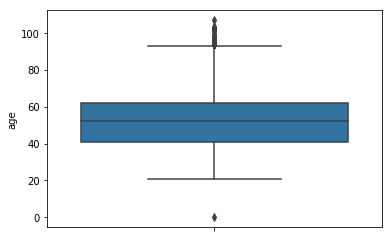

In [6]:
#异常值处理
sns.boxplot(y='age', data=data)

In [7]:
data=data[((data['age']>0) & (data['age']<100))]

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

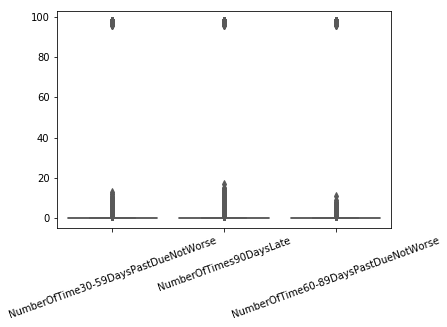

In [8]:
#逾期次数
sns.boxplot(data=data[['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse']], palette='Set2')
plt.xticks(rotation=20)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

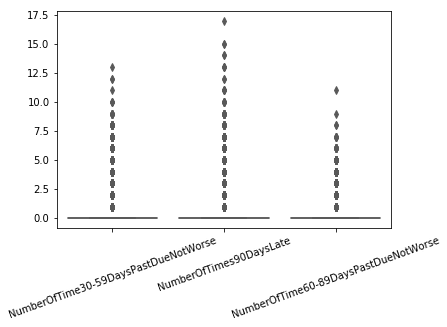

In [9]:
data=data[data['NumberOfTime30-59DaysPastDueNotWorse']<80]
#再次检查异常点
sns.boxplot(data=data[['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse']], palette='Set2')
plt.xticks(rotation=20)

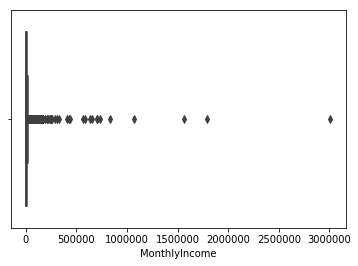

In [10]:
#月收入和年龄变量的分布
sns.boxplot(x='MonthlyIncome', data=data)

99.69% of customers monthly income under 40000.


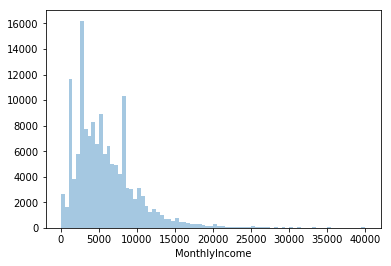

In [11]:
print('%.2f%% of customers monthly income under 40000.' %(data.loc[data['MonthlyIncome']<=40000].shape[0]*100/data.shape[0]))
#月收入绝大部分集中在40000以下，可画出对应的月收入的分布
sns.distplot(data.loc[data['MonthlyIncome']<=40000,'MonthlyIncome'], bins=80, label='MonthlyIncome dist', kde=False)

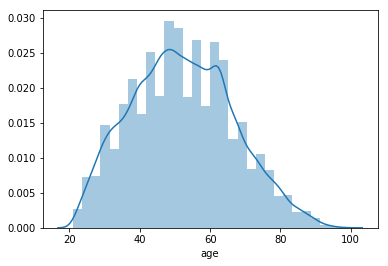

In [12]:
sns.distplot(data['age'], bins=30, label='age dist', kde=True)

#### 特征工程

In [13]:
#训练集与测试集划分
from sklearn.model_selection import train_test_split

y = data['SeriousDlqin2yrs']
X = data.iloc[:,1:]
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=10)

In [14]:
# 定义最优分箱函数
import scipy.stats as stats
def mono_bin(Y, X, n = 20):
    r = 0
    total_bad=Y.sum()
    total_good=Y.count()-total_bad
    #print(total_bad, total_good)
    while np.abs(r) < 1:
        d1 = pd.DataFrame({"X": X, "Y": Y, "Bucket": pd.qcut(X, n)})
        d2 = d1.groupby('Bucket', as_index = True)
        r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
        n = n - 1
    d3 = pd.DataFrame(d2.X.min(), columns = ['min'])
    d3['min']=d2.min().X
    d3['max'] = d2.max().X
    d3['bad'] = d2.sum().Y
    d3['good'] = d2.count().Y-d3['bad']
    d3['bad_rate'] = d2.mean().Y
    d3['woe']=np.log(((d2.count().Y-d2.sum().Y)/total_good)/(d2.sum().Y/total_bad))
    iv = ((d3['good']/total_good - d3['bad']/total_bad)*d3['woe']).sum()
    d4 = (d3.sort_index(by = 'min')).reset_index(drop=True)
    woe = list(d4['woe'].round(3))
    cut=[]
    cut.append(float('-inf'))
    for i in range(1, n+1):
        qua = X.quantile(i / (n+1))
        cut.append(round(qua, 4))
    cut.append(float('inf'))
    
    return d4, iv, cut, woe
     

In [15]:
#举例，将‘age’最优分箱
mono_bin(y, data['age'], n=10)

(   min  max   bad   good  bad_rate       woe
 0   21   33  1816  14471  0.111500 -0.561845
 1   34   40  1664  16073  0.093815 -0.369439
 2   41   45  1360  14683  0.084772 -0.258150
 3   46   49  1209  13619  0.081535 -0.215683
 4   50   54  1298  16516  0.072864 -0.093851
 5   55   59   913  15757  0.054769  0.210948
 6   60   64   690  15923  0.041534  0.501473
 7   65   71   414  14194  0.028341  0.897353
 8   72   99   341  14403  0.023128  1.105954,
 0.2414021266070617,
 [-inf, 33.0, 40.0, 45.0, 49.0, 54.0, 59.0, 64.0, 71.0, inf],
 [-0.562, -0.369, -0.258, -0.216, -0.094, 0.211, 0.501, 0.897, 1.106])

In [16]:
#每个变量的个数，从而确定连续变量与分类变量
var_lst=data.columns[1:]
var_num={}
for var in var_lst:
    var_num[var]=len(data[var].unique())
var_num

{'RevolvingUtilizationOfUnsecuredLines': 122950,
 'age': 79,
 'NumberOfTime30-59DaysPastDueNotWorse': 14,
 'DebtRatio': 114065,
 'MonthlyIncome': 13592,
 'NumberOfOpenCreditLinesAndLoans': 58,
 'NumberOfTimes90DaysLate': 17,
 'NumberRealEstateLoansOrLines': 28,
 'NumberOfTime60-89DaysPastDueNotWorse': 11,
 'NumberOfDependents': 13}

In [17]:
#将四个连续变量最优分箱
x1_df, x1_iv, x1_cut, x1_woe = mono_bin( y_train, X_train['RevolvingUtilizationOfUnsecuredLines'], n=10)
x2_df, x2_iv, x2_cut, x2_woe = mono_bin( y_train, X_train['age'], n=10)
x4_df, x4_iv, x4_cut, x4_woe = mono_bin( y_train, X_train['DebtRatio'], n=10)
x5_df, x5_iv, x5_cut, x5_woe = mono_bin( y_train, X_train['MonthlyIncome'], n=10)

In [18]:
#不能最优分箱的变量则进行手动分箱，WOE计算函数
def woe_value(Y, X, cut):
    total_bad=Y.sum()
    total_good=Y.count()-total_bad
    d1 = pd.DataFrame({"X": X, "Y": Y, "Bucket": cut})
    d2 = d1.groupby('Bucket', as_index = True)
    d3 = pd.DataFrame(d2.X.min(), columns = ['min'])
    d3['min']=d2.min().X
    d3['max'] = d2.max().X
    d3['bad'] = d2.sum().Y
    d3['good'] = d2.count().Y-d3['bad']
    d3['bad_rate'] = d2.mean().Y
    d3['woe']=np.log(((d2.count().Y-d2.sum().Y)/total_good)/(d2.sum().Y/total_bad))
    iv = ((d3['good']/total_good - d3['bad']/total_bad)*d3['woe']).sum()
    d4 = (d3.sort_index(by = 'min')).reset_index(drop=True)
    woe = list(d4['woe'].round(3))
    
    return d4, iv, woe                   

In [19]:
x3_cut = [-np.Inf, 0, 1, 3, 5, np.Inf]
x6_cut = [-np.Inf, 1, 2, 3, 5, np.Inf]
x7_cut = [-np.Inf, 0, 1, 3, 5, np.Inf]
x8_cut = [-np.Inf, 0, 1, 2, 3, np.Inf]
x9_cut = [-np.Inf, 0, 1, 3, np.Inf]
x10_cut = [-np.Inf, 0, 1, 2, 3, 5, np.Inf]

x3_bin = pd.cut(X_train['NumberOfTime30-59DaysPastDueNotWorse'], bins= x3_cut)
x6_bin = pd.cut(X_train['NumberOfOpenCreditLinesAndLoans'], bins= x6_cut)
x7_bin = pd.cut(X_train['NumberOfTimes90DaysLate'], bins=x7_cut)
x8_bin = pd.cut(X_train['NumberRealEstateLoansOrLines'], bins=x8_cut)
x9_bin = pd.cut(X_train['NumberOfTime60-89DaysPastDueNotWorse'], bins=x9_cut)
x10_bin = pd.cut(X_train['NumberOfDependents'], bins=x10_cut)

x3_df, x3_iv, x3_woe = woe_value(y_train, X_train['NumberOfTime30-59DaysPastDueNotWorse'], x3_bin)
x6_df, x6_iv, x6_woe = woe_value(y_train, X_train['NumberOfOpenCreditLinesAndLoans'], x6_bin)
x7_df, x7_iv, x7_woe = woe_value(y_train, X_train['NumberOfTimes90DaysLate'], x7_bin)
x8_df, x8_iv, x8_woe = woe_value(y_train, X_train['NumberRealEstateLoansOrLines'], x8_bin)
x9_df, x9_iv, x9_woe = woe_value(y_train, X_train['NumberOfTime60-89DaysPastDueNotWorse'], x9_bin)
x10_df, x10_iv, x10_woe = woe_value(y_train, X_train['NumberOfDependents'], x10_bin)

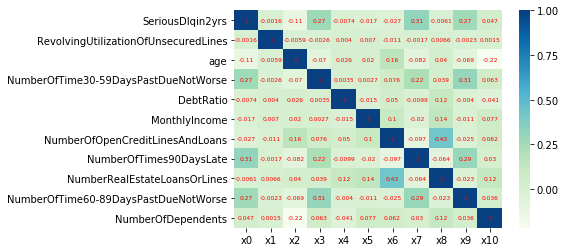

In [20]:
#相关性分析
corr = data.corr()
xticks = ['x'+str(i) for i in range(12)]
yticks = list(data.columns)
fig = plt.figure()
ax1 = fig.add_subplot(111)
sns.heatmap(corr, cmap='GnBu', annot=True, ax= ax1, annot_kws={'size':6, 'color':'red'})
ax1.set_xticklabels(xticks, rotation=0, fontsize=10)
ax1.set_yticklabels(yticks, rotation=0, fontsize=10)
plt.show()

Text(0,0.5,'IV')

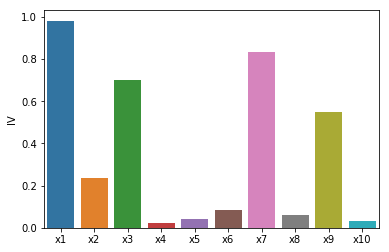

In [21]:
#从相关系数热力图可以看出，自变量之间的线性相关性比较弱
#画出每个变量的IV值
iv = [eval('x'+str(i)+'_iv') for i in range(1,11)]
index=['x'+str(i) for i in range(1,11)]
sns.barplot(x=index, y=iv)
plt.ylabel('IV')

In [22]:
#选x1, x2, x3, x7, x9， IV>0.2高预测性
#WOE编码
x1= 'RevolvingUtilizationOfUnsecuredLines'
x2= 'age'
x3= 'NumberOfTime30-59DaysPastDueNotWorse'
x7= 'NumberOfTimes90DaysLate'
x9= 'NumberOfTime60-89DaysPastDueNotWorse'

#定义WOE编码函数
def woe_trans(data, var, woe, cut):
    woe_name = var+'_woe'
    for i in range(len(woe)):
        if i == 0:
            data.loc[(data[var]<=cut[i+1]), woe_name] = woe[i]
        elif ((i>0) and (i<=(len(woe)-2))):
            data.loc[((data[var]<=cut[i+1]) & (data[var]>cut[i])), woe_name] = woe[i]
        else: 
            data.loc[(data[var]>cut[i]), woe_name] = woe[i]
    return data


In [23]:
for i in [1,2,3,7,9]:
    X_train = woe_trans(X_train, eval('x'+str(i)), eval('x'+str(i)+'_woe'), eval('x'+str(i)+'_cut'))

In [24]:
#选取WOE编码之后的列作为训练数据集
X_train = X_train.iloc[:, -5:]

### 4. 模型开发

In [25]:
#建立逻辑回归模型
import statsmodels.api as sm
X1=sm.add_constant(X_train)
logit=sm.Logit(y_train, X1)
result=logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.185840
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:       SeriousDlqin2yrs   No. Observations:               101740
Model:                          Logit   Df Residuals:                   101734
Method:                           MLE   Df Model:                            5
Date:                Thu, 20 Sep 2018   Pseudo R-squ.:                  0.2382
Time:                        21:57:47   Log-Likelihood:                -18907.
converged:                       True   LL-Null:                       -24820.
                                        LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -2.6

### 5. 模型评估

In [26]:
#对测试集进行WOE编码
for i in [1,2,3,7,9]:
    X_test = woe_trans(X_test, eval('x'+str(i)), eval('x'+str(i)+'_woe'), eval('x'+str(i)+'_cut'))
X_test = X_test.iloc[:, -5:]    

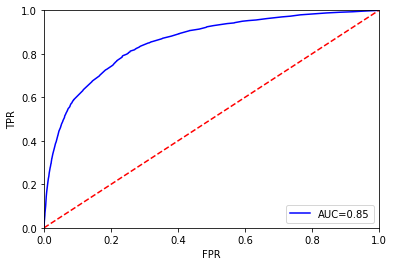

In [27]:
#绘制ROC曲线，计算AUC
from sklearn import metrics
X2=sm.add_constant(X_test)
y_pred = result.predict(X2)

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='AUC=%.2f' %auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

### 6. 评分系统建立

In [28]:
#分数计算函数
PDO=20
base=600
#all_woe是某一个体所有相关变量woe编码值构成的序列
#total_score = base- PDO*(all_woe.dot(coef))/np.log(2)
factor= -PDO/np.log(2)
coef = result.params
def get_score(coef, woe, factor):
    scores=[round(coef*woe[i]*factor, 0) for i in range(len(woe))]
    return scores

In [29]:
#计算各因子每个区间对应的分数
x1_scores=get_score(coef[1], x1_woe, factor)
print(x1_scores)
x2_scores=get_score(coef[2], x2_woe, factor)
x3_scores=get_score(coef[3], x3_woe, factor)
x7_scores=get_score(coef[4], x7_woe, factor)
x9_scores=get_score(coef[5], x9_woe, factor)

[24.0, 23.0, 5.0, -20.0]


In [30]:
data.head()
datacopy=data

In [31]:
data=datacopy

In [32]:
for i in [1,2,3,7,9]:
    data = woe_trans(data, eval('x'+str(i)), eval('x'+str(i)+'_woe'), eval('x'+str(i)+'_cut'))
data = data.iloc[:, -5:]

In [33]:
#对整个data进行打分计算
data_c=sm.add_constant(data)                                         
data['score']=500 + round(data_c.dot(coef)*factor, 0)  
data.head(10)

,RevolvingUtilizationOfUnsecuredLines_woe,age_woe,NumberOfTime30-59DaysPastDueNotWorse_woe,NumberOfTimes90DaysLate_woe,NumberOfTime60-89DaysPastDueNotWorse_woe,score
0,-1.097,-0.264,-1.720,0.373,0.267,534.0
1,-1.097,-0.371,0.515,0.373,0.267,567.0
2,-1.097,-0.371,-0.878,-1.969,0.267,507.0
3,0.284,-0.564,0.515,0.373,0.267,590.0
4,-1.097,-0.184,-0.878,0.373,0.267,548.0
5,0.284,1.094,0.515,0.373,0.267,614.0
6,0.284,0.216,0.515,0.373,0.267,601.0
7,-1.097,-0.371,0.515,0.373,0.267,567.0
9,0.284,0.216,0.515,0.373,0.267,601.0
10,-1.097,-0.564,0.515,0.373,0.267,564.0
